In [39]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [40]:
dices_paths = {
    'central': 'results/central_subset_dice.csv',
    'fedavg': 'results/federated_subset_dice.csv',
}
dices_paths

{'central': 'results/central_subset_dice.csv',
 'fedavg': 'results/federated_subset_dice.csv'}

In [41]:
results_per_dataset = []
dfs = {}
for name, path in dices_paths.items():
    df = pd.read_csv(path, index_col=0)
    # df.replace(0, np.nan, inplace=True)

    
    # df = df[~df.case.isin(amos_bad_cases)]
    structures = df.columns[2:]
    structures = [s.replace('_fun', '') for s in structures]
    structures = np.unique(structures).tolist()
    structures_fun = [f'{s}_fun' for s in structures]

    dfs[name] = df[['case','test_dataset']+structures]
    dfs[f'{name}_fun'] = df[['case','test_dataset']+structures_fun]

    df['case'] = df.case.apply(lambda x: '_'.join(x.split('_')[:-1]))

    mean_per_case = df[['test_dataset', 'case']+structures].groupby(['test_dataset', 'case']).apply(lambda x: x[structures].apply(lambda y: y.mean())).reset_index()
    mean_per_dataset = mean_per_case.groupby('test_dataset').apply(lambda x: x[structures].apply(lambda y: y.mean()))
    # print(name, mean_per_dataset)
    mean_per_dataset = mean_per_dataset.apply(lambda x: x.mean(), axis=1)

    if 'aorta_fun' in df.columns:
        mean_per_case_fun = df[['test_dataset', 'case']+structures_fun].groupby(['test_dataset', 'case']).apply(lambda x: x[structures_fun].apply(lambda y: y.mean())).reset_index()
        mean_per_dataset_fun = mean_per_case_fun.groupby('test_dataset').apply(lambda x: x[structures_fun].apply(lambda y: y.mean()))
        mean_per_dataset_fun = mean_per_dataset_fun.apply(lambda x: x.mean(), axis=1)
    else:
        mean_per_dataset_fun = pd.Series([np.nan]*len(mean_per_dataset), index=mean_per_dataset.index)
        
    for ds in mean_per_dataset.index:
        results_per_dataset.append({'method': name, 'dataset': ds, 'dice': mean_per_dataset[ds], 'dice_fun': mean_per_dataset_fun[ds]})

In [42]:
_df = pd.DataFrame(results_per_dataset)
results_per_dataset = []
for ds_name in _df.dataset.unique():
    # same_dice = _df[(_df.method==ds_name)&(_df.dataset==ds_name)].dice#.mean().item() * 100, 2)
    # other_dice = _df[(_df.method==ds_name)&(_df.dataset!=ds_name)].dice#.mean().item() * 100, 2)
    results_per_dataset.append({
        'dataset': ds_name,
        # 'dice_condistfl': np.round(_df[(_df.dataset==ds_name) & (_df.method=='condistfl')]['dice'].item() * 100, 2),
        # 'same': np.round(same_dice[same_dice>0].mean() * 100, 2),
        # 'other': np.round(other_dice[other_dice>0].mean() * 100, 2),
        'dice_cen_van': np.round(_df[(_df.dataset==ds_name) & (_df.method=='central')]['dice'].item() * 100, 2),
        'dice_cen_fun': np.round(_df[(_df.dataset==ds_name) & (_df.method=='central')]['dice_fun'].item() * 100, 2),
        'dice_fedavg_van': np.round(_df[(_df.dataset==ds_name) & (_df.method=='fedavg')]['dice'].item() * 100, 2),
        'dice_fedavg_fun': np.round(_df[(_df.dataset==ds_name) & (_df.method=='fedavg')]['dice_fun'].item() * 100, 2),
        # 'dice_fedprox_van': np.round(_df[(_df.dataset==ds_name) & (_df.method=='fedprox')]['dice'].item() * 100, 2),
        # 'dice_fedprox_fun': np.round(_df[(_df.dataset==ds_name) & (_df.method=='fedprox')]['dice_fun'].item() * 100, 2)
    })
df_dice_per_dataset = pd.DataFrame(results_per_dataset)
df_dice_per_dataset.set_index('dataset', inplace=True)
df_dice_per_dataset = df_dice_per_dataset.T
df_dice_per_dataset['mean'] = np.round(df_dice_per_dataset.mean(axis=1), 2)
df_dice_per_dataset

dataset,Dataset001_visceral_gc,Dataset002_visceral_sc,Dataset004_lits,Dataset005_bcv_abdomen,Dataset006_bcv_cervix,Dataset007_chaos,Dataset009_abdomenct1k,Dataset014_learn2reg,Dataset037_totalsegmentator,Dataset038_amos,mean
dice_cen_van,87.44,77.52,91.24,84.56,85.05,95.41,82.98,87.95,69.65,55.57,81.74
dice_cen_fun,83.18,74.51,87.95,82.39,80.40,92.86,80.16,85.91,69.07,57.60,79.40
dice_fedavg_van,85.12,77.67,92.51,84.22,78.25,91.92,87.73,85.11,77.94,65.94,82.64
dice_fedavg_fun,85.31,77.26,93.06,86.87,78.88,94.63,86.63,86.35,85.19,73.49,84.77


In [43]:
order = ['Dataset002_visceral_sc', 'Dataset004_lits',
         'Dataset005_bcv_abdomen', 'Dataset006_bcv_cervix', 'Dataset007_chaos',
         'Dataset009_abdomenct1k', 'Dataset014_learn2reg',
         'Dataset037_totalsegmentator', 'Dataset001_visceral_gc', 'Dataset038_amos', 'mean']
methods = ['Cen Avg', 'CUNAvg', 'Fed Avg', 'FUNAvg']
print('VSC & LiTS & Abd & Cvx & Chao & A1k & L2R & TS & VGC & Amo & M \\\\')
for j, (i, row) in enumerate(df_dice_per_dataset[order].iterrows()):
    print(methods[j], '&',' & '.join([str(x) for x in row]), '\\\\')
    # print(row.mean())

VSC & LiTS & Abd & Cvx & Chao & A1k & L2R & TS & VGC & Amo & M \\
Cen Avg & 77.52 & 91.24 & 84.56 & 85.05 & 95.41 & 82.98 & 87.95 & 69.65 & 87.44 & 55.57 & 81.74 \\
CUNAvg & 74.51 & 87.95 & 82.39 & 80.4 & 92.86 & 80.16 & 85.91 & 69.07 & 83.18 & 57.6 & 79.4 \\
Fed Avg & 77.67 & 92.51 & 84.22 & 78.25 & 91.92 & 87.73 & 85.11 & 77.94 & 85.12 & 65.94 & 82.64 \\
FUNAvg & 77.26 & 93.06 & 86.87 & 78.88 & 94.63 & 86.63 & 86.35 & 85.19 & 85.31 & 73.49 & 84.77 \\


In [44]:
dfs['central_fun'].rename(columns={c: c.replace('_fun', '') for c in dfs['central_fun'].columns}, inplace=True)
dfs['fedavg_fun'].rename(columns={c: c.replace('_fun', '') for c in dfs['fedavg_fun'].columns}, inplace=True)

In [45]:
dices_per_case = []
for n, v in dfs.items():
    v['mean'] = v[structures].mean(axis=1)
    dices_per_case.append(v[['case','test_dataset','mean']].set_index('case').rename(columns={'mean': n}).reset_index())

In [46]:
dices_per_case_np = np.array([[d.loc[c].iloc[-1].item() for d in dices_per_case] for c in dices_per_case[0].index])
df_per_case = pd.DataFrame(dices_per_case_np, columns=['Cen Avg', 'CUNAvg', 'Fed Avg', 'FUNAvg'])
df_per_case['test_dataset'] = dices_per_case[0]['test_dataset']
df_per_case

,Cen Avg,CUNAvg,Fed Avg,FUNAvg,test_dataset
0,0.175806,0.169422,0.231119,0.203509,Dataset037_totalsegmentator
1,0.678617,0.657009,0.742220,0.661424,Dataset037_totalsegmentator
2,0.958814,0.910453,0.961125,0.942670,Dataset037_totalsegmentator
3,0.954762,0.973262,0.958893,0.970998,Dataset037_totalsegmentator
4,0.943820,0.964286,0.954017,0.964988,Dataset037_totalsegmentator
...,...,...,...,...,...
2945,0.939236,0.930733,0.937901,0.939799,Dataset004_lits
2946,0.927828,0.907300,0.944762,0.927369,Dataset004_lits
2947,0.928525,0.908824,0.957797,0.933736,Dataset004_lits
2948,0.803170,0.757790,0.845227,0.813559,Dataset004_lits


In [47]:
from scipy.stats import ttest_ind

p_val = lambda x1, x2, ds: np.round(ttest_ind(df_per_case[df_per_case.test_dataset == ds][x1], df_per_case[df_per_case.test_dataset == ds][x2]).pvalue, 2)
ps_central, ps_fed = [], []
for ds in order[:-1]:
    p_cenavg_cun = p_val('Cen Avg', 'CUNAvg', ds)
    p_fedavg_fun = p_val('Fed Avg', 'FUNAvg', ds)
    ps_central.append('$<0.01$' if p_cenavg_cun < 0.01 else str(p_cenavg_cun))
    ps_fed.append('$<0.01$' if p_fedavg_fun < 0.01 else str(p_fedavg_fun))
mean_p_cen = np.round(ttest_ind(df_per_case['Cen Avg'], df_per_case['CUNAvg']).pvalue, 2)
mean_p_fed = np.round(ttest_ind(df_per_case['Fed Avg'], df_per_case['FUNAvg']).pvalue, 2)
mean_p_cen = '$<0.01$' if mean_p_cen < 0.01 else str(mean_p_cen)
mean_p_fed = '$<0.01$' if mean_p_fed < 0.01 else str(mean_p_fed)
print('& \\tiny ' + ' & \\tiny '.join(ps_central) + f'& \\tiny {mean_p_cen}' +  ' \\\\')
print('& \\tiny ' + ' & \\tiny '.join(ps_fed) + f'& \\tiny {mean_p_fed}' + ' \\\\')


& \tiny $<0.01$ & \tiny $<0.01$ & \tiny 0.02 & \tiny 0.07 & \tiny 0.03 & \tiny 0.01 & \tiny 0.41 & \tiny 0.35 & \tiny $<0.01$ & \tiny 0.63& \tiny $<0.01$ \\
& \tiny 0.04 & \tiny 0.45 & \tiny 0.01 & \tiny 0.89 & \tiny 0.19 & \tiny 0.54 & \tiny 0.78 & \tiny 0.03 & \tiny 0.8 & \tiny $<0.01$& \tiny 0.07 \\


## DICE PER STRUCTURE

In [48]:
dices_paths

{'central': 'results/central_subset_dice.csv',
 'fedavg': 'results/federated_subset_dice.csv'}

In [57]:
_results_per_structure = {}
results_per_dataset_and_structue = {}
for name, path in dices_paths.items():
    df = pd.read_csv(path, index_col=0)
    # df.replace(0, np.nan, inplace=True)

    df['case'] = df.case.apply(lambda x: '_'.join(x.split('_')[:-1]))
    # df = df[~df.case.isin(amos_bad_cases)]
    structures = df.columns[2:]
    structures = [s.replace('_fun', '') for s in structures]
    structures = np.unique(structures).tolist()

    mean_per_case = df.groupby(['case', 'test_dataset']).mean().reset_index()
    mean_per_structure = mean_per_case.groupby('test_dataset')[structures].mean().mean(axis=0)

    results_per_dataset_and_structue[name] = mean_per_case.groupby('test_dataset')[structures].mean()
    
    _results_per_structure[f'{name}_van'] = mean_per_structure 
    if 'aorta_fun' in df.columns:
        mean_per_structure_fun = mean_per_case.groupby('test_dataset')[structures_fun].mean().mean(axis=0)
        _results_per_structure[f'{name}_fun'] = mean_per_structure_fun

        results_per_dataset_and_structue[f'{name}_fun'] = mean_per_case.groupby('test_dataset')[structures_fun].mean()# .rename(columns={s1:s2 for s1,s2 in zip(structures_fun,structures)})
    else:
        _results_per_structure[f'{name}_fun'] = pd.Series([np.nan]*len(structures_fun), index=structures_fun)

results_per_structure = []
for s in structures:
    s_results = {'structure': s}
    for m, vals in _results_per_structure.items():
        _s = f'{s}_fun' if 'fun' in m else s
        s_results[m] = np.round(vals.loc[_s] * 100,1)
    results_per_structure.append(s_results)
df_dice_per_structure = pd.DataFrame(results_per_structure)
df_dice_per_structure.set_index('structure', inplace=True)
df_dice_per_structure = df_dice_per_structure.T#.set_index('structure')
df_dice_per_structure['mean'] = df_dice_per_structure.mean(axis=1).round(1)
df_dice_per_structure

structure,aorta,duodenum,esophagous,gall bladder,left kidney,liver,pancreas,right kidney,spleen,stomach,trachea,urinary bladder,mean
central_van,87.4,0.0,55.2,0.0,83.4,89.7,65.1,84.9,89.3,72.9,90.3,74.5,66.1
central_fun,82.4,0.0,74.1,0.0,83.0,86.8,61.8,83.8,86.4,73.3,87.7,70.8,65.8
fedavg_van,88.9,12.6,80.2,60.9,81.9,90.5,70.4,83.9,90.1,55.6,91.6,73.3,73.3
fedavg_fun,88.1,51.3,81.7,73.5,85.3,91.3,66.2,86.5,90.2,78.7,92.8,71.8,79.8


In [58]:
for i, row in df_dice_per_structure.iterrows():
    print(' & '.join([str(x) for x in row]))

87.4 & 0.0 & 55.2 & 0.0 & 83.4 & 89.7 & 65.1 & 84.9 & 89.3 & 72.9 & 90.3 & 74.5 & 66.1
82.4 & 0.0 & 74.1 & 0.0 & 83.0 & 86.8 & 61.8 & 83.8 & 86.4 & 73.3 & 87.7 & 70.8 & 65.8
88.9 & 12.6 & 80.2 & 60.9 & 81.9 & 90.5 & 70.4 & 83.9 & 90.1 & 55.6 & 91.6 & 73.3 & 73.3
88.1 & 51.3 & 81.7 & 73.5 & 85.3 & 91.3 & 66.2 & 86.5 & 90.2 & 78.7 & 92.8 & 71.8 & 79.8


In [38]:
datasets_short = ['VSC', 'LiTS', 'Abd', 'Cvx', 'Chao', 'Abd1k', 'L2R', 'TS', 'VGC', 'AMOS']
methods_short = {'central': 'Cen', 'central_fun': 'CUN', 'fedavg': 'Fed', 'fedavg_fun': 'FUN'}

for i, ds in enumerate(order[:-1]):
    for n, v in results_per_dataset_and_structue.items():
        v = v.loc[ds]
        v = [str(np.round(x*100,2)) if not np.isnan(x) else '-' for x in v]
        print(datasets_short[i], '&', methods_short[n], '&', ' & '.join(v), '\\\\')

VSC & Cen & 80.44 & - & - & - & 79.36 & 89.23 & 42.77 & 84.44 & 85.91 & - & 92.57 & 65.45 \\
VSC & CUN & 73.53 & - & - & - & 80.73 & 84.91 & 39.11 & 84.59 & 81.75 & - & 88.32 & 63.18 \\
VSC & Fed & 83.05 & - & - & - & 78.47 & 90.86 & 43.19 & 79.36 & 87.92 & - & 93.82 & 64.7 \\
VSC & FUN & 80.02 & - & - & - & 80.38 & 90.49 & 39.94 & 83.28 & 86.86 & - & 92.15 & 64.99 \\
LiTS & Cen & - & - & - & - & - & 91.24 & - & - & - & - & - & - \\
LiTS & CUN & - & - & - & - & - & 87.95 & - & - & - & - & - & - \\
LiTS & Fed & - & - & - & - & - & 92.51 & - & - & - & - & - & - \\
LiTS & FUN & - & - & - & - & - & 93.06 & - & - & - & - & - & - \\
Abd & Cen & 91.31 & - & - & - & 91.67 & 90.35 & 64.5 & 89.61 & 92.03 & 72.47 & - & - \\
Abd & CUN & 85.82 & - & - & - & 89.65 & 87.39 & 62.01 & 88.92 & 90.46 & 72.45 & - & - \\
Abd & Fed & 91.5 & - & - & - & 88.98 & 92.87 & 74.01 & 91.3 & 93.36 & 57.5 & - & - \\
Abd & FUN & 91.9 & - & - & - & 91.59 & 92.67 & 67.71 & 91.96 & 94.35 & 77.94 & - & - \\
Cvx & Cen & - 

In [21]:
mean_per_case.groupby('test_dataset')[structures].mean()

,aorta,duodenum,esophagous,gall bladder,left kidney,liver,pancreas,right kidney,spleen,stomach,trachea,urinary bladder
test_dataset,,,,,,,,,,,,
Dataset001_visceral_gc,0.883700,NaN,NaN,NaN,0.813256,0.925536,0.740864,0.817725,0.943518,NaN,0.935354,0.749438
Dataset002_visceral_sc,0.830516,NaN,NaN,NaN,0.784679,0.908610,0.431896,0.793594,0.879245,NaN,0.938188,0.646953
Dataset004_lits,NaN,NaN,NaN,NaN,NaN,0.925147,NaN,NaN,NaN,NaN,NaN,NaN
Dataset005_bcv_abdomen,0.915024,NaN,NaN,NaN,0.889758,0.928709,0.740135,0.913020,0.933617,0.574969,NaN,NaN
Dataset006_bcv_cervix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782547
Dataset007_chaos,NaN,NaN,NaN,NaN,NaN,0.919240,NaN,NaN,NaN,NaN,NaN,NaN
Dataset009_abdomenct1k,NaN,NaN,NaN,NaN,NaN,0.918112,0.789090,NaN,0.924594,NaN,NaN,NaN
Dataset014_learn2reg,NaN,NaN,NaN,NaN,NaN,0.864868,NaN,NaN,0.837297,NaN,NaN,NaN
Dataset037_totalsegmentator,0.935877,0.174782,0.882683,0.666077,0.832020,0.897789,0.812870,0.910429,0.941816,0.671340,0.873082,0.754394


In [12]:
from train import LABEL_SUBSETS
all_labels = [LABEL_SUBSETS[ds_name] for ds_name in LABEL_SUBSETS.keys()]
all_labels, counts = np.unique([xx for x in all_labels for xx in x], return_counts=True)
n_cls_per_organ = pd.Series(counts-1, index=all_labels)

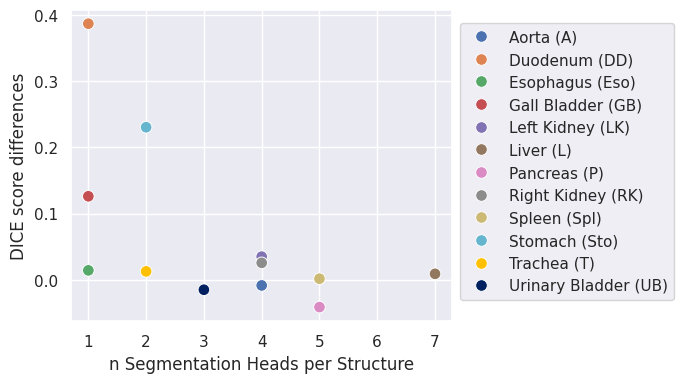

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

structure_names = {
    'aorta': 'Aorta (A)',
    'duodenum': 'Duodenum (DD)',
    'esophagous': 'Esophagus (Eso)',
    'gall bladder': 'Gall Bladder (GB)',
    'left kidney': 'Left Kidney (LK)',
    'liver': 'Liver (L)',
    'pancreas': 'Pancreas (P)',
    'right kidney': 'Right Kidney (RK)',
    'spleen': 'Spleen (Spl)',
    'stomach': 'Stomach (Sto)',
    'trachea': 'Trachea (T)',
    'urinary bladder': 'Urinary Bladder (UB)',
}

sns.set()

y = df_dice_per_structure.T.loc['fedavg_fun'] - df_dice_per_structure.T.loc['fedavg_van']
x = n_cls_per_organ
x.index = [structure_names[i] for i in x.index]
y.index = [structure_names[i] for i in y.index]

colors = sns.color_palette() + [(1.,192/255,0.), (0.,32/255,96/255)] # yellow + blue
cp = sns.color_palette(colors)
cp = {l: c for l, c in zip(n_cls_per_organ.index, cp)}

df_mean_per_organ_diff = pd.DataFrame({
    'n_cls_per_organ': n_cls_per_organ, 
    'difference': y, 
}).reset_index().rename(columns={'index': 'organ'})
fig, ax = plt.subplots(1,1,figsize=(7,4))
sns.scatterplot(df_mean_per_organ_diff, x='n_cls_per_organ', y='difference', hue='organ', ax=ax, palette=cp, s=70) # , style="organ")
ax.legend(bbox_to_anchor=(1.0,0.98))
ax.set_xlabel('n Segmentation Heads per Structure')
ax.set_ylabel('DICE score differences')
fig.tight_layout()
fig.savefig('improvement_funavg_rebuttal.png', bbox_inches='tight')